In [6]:
import sys, os
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import weatherbench2 as wb
import metpy
import copy
import wrf
import time
from metpy.units import units
sys.path.append('/users/mfeldman/code/xarray_parcel/')
import modules.parcel_functions as parcel
parcel.load_moist_adiabat_lookups()
print('modules loaded')

modules loaded


In [7]:
hres='gs://weatherbench2/datasets/hres/2016-2022-0012-1440x721.zarr'
era5='gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr'
pangu='gs://weatherbench2/datasets/pangu/2018-2022_0012_0p25.zarr'
datasets=[era5,hres,pangu]

for dataset in datasets[:1]:
    print(dataset)
    xr_dataset=xr.open_zarr(dataset)
    xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.year.isin([2020]))
    xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.month.isin([7]))#np.arange(3,10)))
    xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.day.isin([1]))
    xr_dataset = xr_dataset.sortby('level', ascending=False)
    #xr_dataset=xr_dataset.sel(time=xr_dataset.time.dt.hour.isin([12]))
    print(xr_dataset.time)
    #xr_dataset=xr_dataset.drop_dims("time")
    plevel=copy.deepcopy(xr_dataset.level.values)
    #xr_dataset.level=np.arange(len(plevel))
    
    #xr_dataset = xr_dataset.assign(pressure=('level'), data=plevel)
    xr_dataset['pressure'] = (('level'), plevel)
    plevel=xr_dataset.pressure
    xr_dataset = xr_dataset.assign_coords(level=np.arange(len(plevel)))

    tlevel=xr_dataset.temperature
    qlevel=xr_dataset.specific_humidity
    plevel_dim=np.ones([1,len(plevel),1,1])
    zlevel=xr_dataset.geopotential
    for n1 in range(len(plevel.data)):
        plevel_dim[0,n1,0,0]=plevel[n1]
    plevel_exp=(tlevel/tlevel)*plevel_dim
    dplevel=metpy.calc.dewpoint_from_specific_humidity(plevel_exp* units('hPa'), tlevel* units('K'), qlevel* units('kg/kg'))#.magnitude
    dplevel.data=dplevel.data.to(units.K).magnitude

gs://weatherbench2/datasets/era5/1959-2022-6h-1440x721.zarr
<xarray.DataArray 'time' (time: 4)>
array(['2020-07-01T00:00:00.000000000', '2020-07-01T06:00:00.000000000',
       '2020-07-01T12:00:00.000000000', '2020-07-01T18:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-07-01 ... 2020-07-01T18:00:00


/tmp/ipykernel_414686/3904734776.py:31: UserWarning: Relative humidity >120%, ensure proper units.
  dplevel=metpy.calc.dewpoint_from_specific_humidity(plevel_exp* units('hPa'), tlevel* units('K'), qlevel* units('kg/kg'))#.magnitude


In [8]:
    psurf=xr_dataset.mean_sea_level_pressure
    tsurf=xr_dataset['2m_temperature']
    zsurf_c=xr_dataset['geopotential_at_surface']; print(zsurf_c.shape,zsurf_c.dims)
    zsurf = zsurf_c.expand_dims(dim={"time": psurf.time}, axis=0); print(zsurf.shape)
    n1=0
    pid=np.zeros(psurf.shape)
    for lev in plevel:
        n1+=1
        pid[(pid==0) & (psurf<lev*100)]=n1
    qlow=xr_dataset.specific_humidity.isel(level=0)
    qsurf_interp = xr_dataset.specific_humidity.isel(level=1) + ( (xr_dataset.specific_humidity.isel(level=0) - xr_dataset.specific_humidity.isel(level=1)) \
                                * ((np.log(psurf) - np.log(plevel[0]*100) ) / ( np.log(plevel[1]*100) - np.log(plevel[0]*100) ) ) )

    qsurf = (psurf.data<100000) * qsurf_interp + (psurf.data>=100000) * qlow

    dpsurf=metpy.calc.dewpoint_from_specific_humidity(psurf* units('Pa'), tsurf* units('K'), qsurf* units('kg/kg'))#.magnitude
    dpsurf.data=dpsurf.data.to(units.K).magnitude  
    

(721, 1440) ('latitude', 'longitude')
(4, 721, 1440)


/tmp/ipykernel_414686/612864762.py:16: UserWarning: Relative humidity >120%, ensure proper units.
  dpsurf=metpy.calc.dewpoint_from_specific_humidity(psurf* units('Pa'), tsurf* units('K'), qsurf* units('kg/kg'))#.magnitude


In [9]:
    print(plevel_exp.shape,tlevel.shape,dplevel.shape,tsurf.shape,psurf.shape,dpsurf.shape,zsurf.shape,zlevel.shape)
    print(parcel.valid_data(xr_dataset, vert_dim='level'))

(4, 13, 721, 1440) (4, 13, 721, 1440) (4, 13, 721, 1440) (4, 721, 1440) (4, 721, 1440) (4, 721, 1440) (4, 721, 1440) (4, 13, 721, 1440)
True


In [14]:
    
    ps=psurf/100
    zs=zsurf/9.81
    zl=zlevel/9.81
    cape=wrf.cape_2d(pres_hpa=plevel_exp, tkel=tlevel, qv=qlevel, height=zl, terrain=zs, psfc_hpa=ps, ter_follow=False)

In [ ]:
#p=plt.imshow(zl[0,0,:,:]>0); plt.colorbar(p); plt.show()
#p=plt.imshow(zs[0,:,:]>0); plt.colorbar(p); plt.show()
print(cape.dims)
import cartopy.crs as ccrs
#p=plt.imshow(cape[0,3,:,:],vmin=0,vmax=6000,cmap='Reds'); plt.colorbar(p); plt.show()
print('georeferenced plot')#,psurf.longitude,cape.latitude)
ax = plt.axes(projection=ccrs.PlateCarree())
p=plt.contourf(psurf.longitude, psurf.latitude, cape[0,3,:,:],10,transform=ccrs.PlateCarree(),cmap='Reds',vmin=0,vmax=3000,)
plt.colorbar(p)
ax.coastlines()
plt.show()

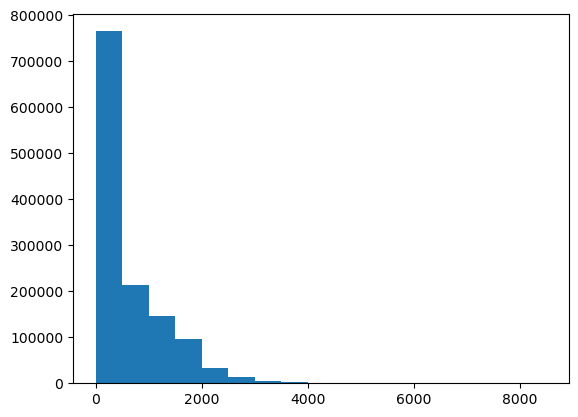

2

In [40]:
plt.hist(cape.data[0,:,:,:].flatten(),bins=np.arange(0,9000,500)); plt.show()
np.nansum(cape.data[0,:,:,:]>8000)


In [12]:
    print('begin CAPE computation')
    #cape_cin, array = parcel.cape_cin(plevel_exp.squeeze(dim="time"), tlevel.squeeze(dim="time"), dplevel.squeeze(dim="time"), tsurf.squeeze(dim="time"), psurf.squeeze(dim="time"),
    #         dpsurf.squeeze(dim="time"), vert_dim='level',template=tsurf.squeeze(dim="time"))
    cape_cin, array = parcel.cape_cin(plevel.chunk(), tlevel.chunk(), dplevel.chunk(), tsurf.chunk(), psurf.chunk(),
             dpsurf.chunk(), vert_dim='level')


begin CAPE computation


Exception: Cannot infer object returned from running user provided function. Please supply the 'template' kwarg to map_blocks.

<xarray.DataArray 'mean_sea_level_pressure' (time: 4, latitude: 721,
                                             longitude: 1440)>
dask.array<lt, shape=(4, 721, 1440), dtype=bool, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2020-07-01 ... 2020-07-01T18:00:00
[ 95251.57   95251.85   95256.06  ... 104175.836 104180.62  104191.86 ]


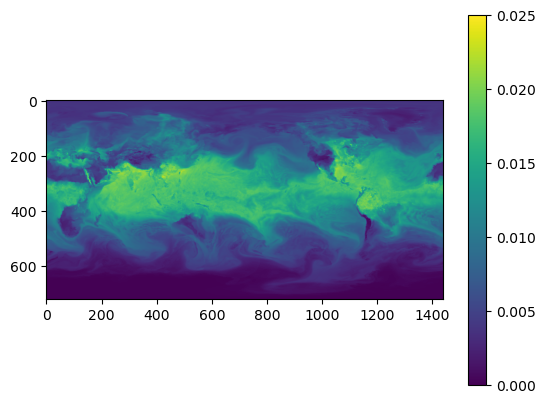

hello


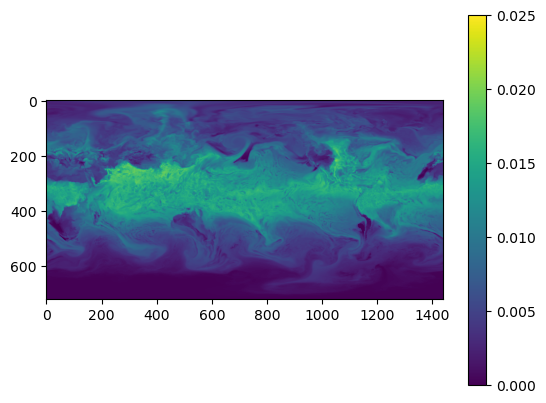

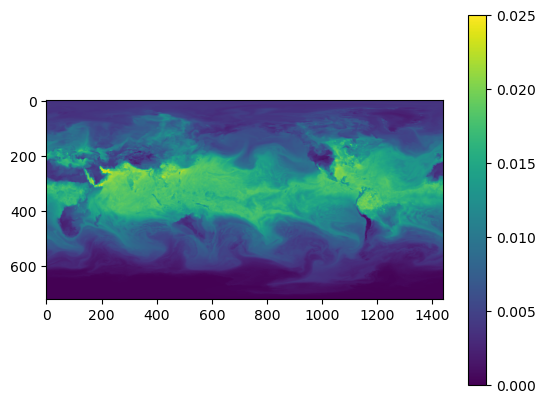

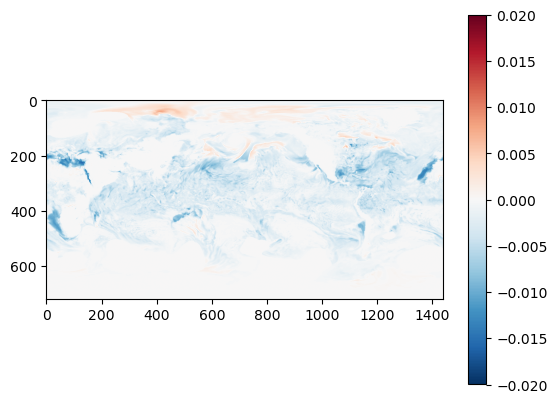

In [10]:
print(psurf<100000)
print(np.unique(psurf))
p=plt.imshow(qsurf[0,:,:],vmin=0, vmax=0.025); plt.colorbar(p)
plt.show()
print('hello')
p=plt.imshow(qsurf_interp[0,:,:],vmin=0, vmax=0.025); plt.colorbar(p)
plt.show()
p=plt.imshow(qlow[0,:,:],vmin=0, vmax=0.025); plt.colorbar(p)
plt.show()

p=plt.imshow((qsurf_interp-qsurf)[0,:,:],vmin=-0.02,vmax=0.02,cmap='RdBu_r'); plt.colorbar(p)
plt.show()